In [1]:
from scipy.io import loadmat 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
from svhn_utils import one_hot, pad_one_hots, shuffle
from training_utils import get_pred, accuracy, train_model

In [2]:
matplotlib.style.use("ggplot")
%matplotlib inline

In [3]:
import pickle

In [4]:
train_mat = pickle.load(open('./data/tensors/train.pkl', 'rb'))
test_mat = pickle.load(open('./data/tensors/test.pkl', 'rb'))

train_y = train_mat['labels'].reshape(-1)
test_y = test_mat['labels'].reshape(-1)
train_files = train_mat['files']
test_files = test_mat['files']

In [5]:
imagenet_mean = np.array([103.939, 116.779, 123.68], dtype=np.float32)
train_x = train_mat['data'].astype('float32')
del train_mat
# train_x = train_x / 255.0 - 0.5
train_x = train_x - imagenet_mean

In [6]:
test_x = test_mat['data'].astype('float32')
del test_mat
# test_x = test_x / 255.0 - 0.5
test_x = test_x - imagenet_mean

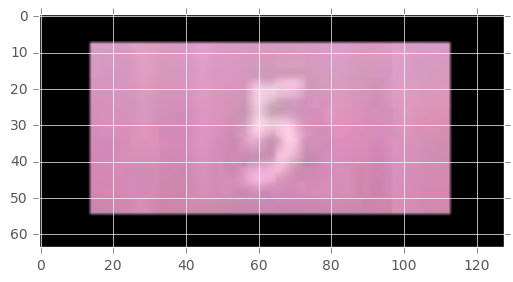

In [7]:
# plt.imshow((test_x[0] + 0.5) * 255)
plt.imshow((test_x[0] + imagenet_mean))

In [8]:
train_x, train_y = shuffle(train_x, train_y)
# test_x, test_y = shuffle(test_x, test_y)

In [9]:
train_y.shape

(33402,)

In [10]:
pd.Series([len(y) for y in train_y]).value_counts()

2    18130
3     8691
1     5137
4     1434
5        9
6        1
dtype: int64

In [11]:
pd.Series([len(y) for y in test_y]).value_counts()

2    8356
1    2483
3    2081
4     146
5       2
dtype: int64

In [12]:
train_y_lens = np.array([len(y) for y in train_y])
train_y = train_y[train_y_lens <= 5] 
train_x = train_x[train_y_lens <= 5]

In [13]:
def format_labels(y):
    y = np.array([one_hot(_y) for _y in y]).reshape([-1])
    return np.array([pad_one_hots(_y) for _y in y])
train_y = format_labels(train_y)
test_y = format_labels(test_y)

In [14]:
train_y.shape

(33401, 5, 11)

In [15]:
valid_x = train_x[:len(train_x)//4]
valid_y = train_y[:len(train_y)//4]
train_x = train_x[len(train_x)//4:]
train_y = train_y[len(train_y)//4:]

In [16]:
import models
import imp
imp.reload(models)

Using TensorFlow backend.


<module 'models' from '/home/ubuntu/Notebooks/models.py'>

# Trying deeper model v2

In [17]:
deeper_model_v7 = models.make_deeper_model_v7(train_x.shape)

In [52]:
[layer.output_shape for layer in deeper_model_v7.layers]

[(None, 64, 128, 3),
 (None, 64, 128, 5),
 (None, 64, 128, 25),
 (None, 64, 128, 50),
 (None, 32, 64, 50),
 (None, 32, 64, 50),
 (None, 32, 64, 100),
 (None, 32, 64, 200),
 (None, 16, 32, 200),
 (None, 16, 32, 200),
 (None, 16, 32, 200),
 (None, 16, 32, 200),
 (None, 8, 16, 200),
 (None, 8, 16, 200),
 (None, 8, 16, 100),
 (None, 8, 16, 50),
 (None, 4, 8, 50),
 (None, 1600),
 (None, 200),
 (None, 200),
 (None, 55),
 (None, 5, 11),
 (None, 5, 11)]

154.74 minutes for epoch
capture_performance2(): valid accuracy 0.681437125748503
Epoch 29
Validation accuracy 68.144%
Mean batch dig loss 0.158
Valid dig loss 0.502


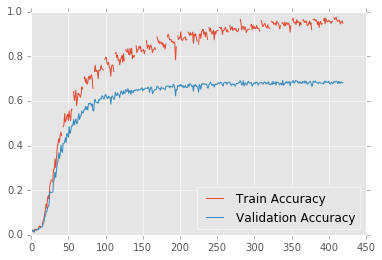

5313.94 minutes total elapsed


In [53]:
deeper_model_v7, train_acc, valid_acc = train_model(deeper_model_v7, train_x, train_y, 
                                                    valid_x, valid_y, n_epochs=30, 
                                                    batch_size=20)

# Trying to fine tune VGG16

In [18]:
vgg_model_v = models.make_vgg_model_v1(train_x[0].shape)

57835520/58889256 [============================>.] - ETA: 0s

In [59]:
[layer.output_shape for layer in vgg_model_v1.layers]

[(None, 64, 128, 3),
 (None, 64, 128, 64),
 (None, 64, 128, 64),
 (None, 32, 64, 64),
 (None, 32, 64, 128),
 (None, 32, 64, 128),
 (None, 16, 32, 128),
 (None, 16, 32, 256),
 (None, 16, 32, 256),
 (None, 16, 32, 256),
 (None, 8, 16, 256),
 (None, 8, 16, 512),
 (None, 8, 16, 512),
 (None, 8, 16, 512),
 (None, 4, 8, 512),
 (None, 4, 8, 512),
 (None, 4, 8, 512),
 (None, 4, 8, 512),
 (None, 2, 4, 512),
 (None, 4096),
 (None, 1000),
 (None, 1000),
 (None, 1000),
 (None, 1000),
 (None, 55),
 (None, 5, 11),
 (None, 5, 11)]

In [60]:
vgg_model_v1, train_acc, valid_acc = train_model(vgg_model_v1, train_x, train_y, 
                                                 valid_x, valid_y, n_epochs=50, 
                                                 batch_size=20)

capture_performance2(): valid accuracy 0.018562874251497007
capture_performance2(): valid accuracy 0.020958083832335328
capture_performance2(): valid accuracy 0.020958083832335328


KeyboardInterrupt: 

# Trying to fine tune VGG16 with different optimizer...

In [19]:
imp.reload(models)

<module 'models' from '/home/ubuntu/Notebooks/models.py'>

In [20]:
vgg_model_v2 = models.make_vgg_model_v2(train_x[0].shape)

In [21]:
[layer.output_shape for layer in vgg_model_v2.layers]

[(None, 64, 128, 3),
 (None, 64, 128, 64),
 (None, 64, 128, 64),
 (None, 32, 64, 64),
 (None, 32, 64, 128),
 (None, 32, 64, 128),
 (None, 16, 32, 128),
 (None, 16, 32, 256),
 (None, 16, 32, 256),
 (None, 16, 32, 256),
 (None, 8, 16, 256),
 (None, 8, 16, 512),
 (None, 8, 16, 512),
 (None, 8, 16, 512),
 (None, 4, 8, 512),
 (None, 4, 8, 512),
 (None, 4, 8, 512),
 (None, 4, 8, 512),
 (None, 2, 4, 512),
 (None, 4096),
 (None, 1000),
 (None, 1000),
 (None, 1000),
 (None, 1000),
 (None, 55),
 (None, 5, 11),
 (None, 5, 11)]

26.31 minutes for epoch
capture_performance2(): valid accuracy 0.6983233532934132
Epoch 5
Validation accuracy 69.832%
Mean batch dig loss 0.245
Valid dig loss 0.336


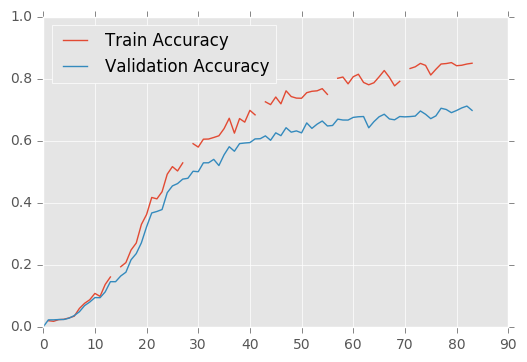

capture_performance2(): valid accuracy 0.6967664670658683
capture_performance2(): valid accuracy 0.7044311377245509
capture_performance2(): valid accuracy 0.7088622754491017


KeyboardInterrupt: 

In [22]:
vgg_model_v2, train_acc3, valid_acc3 = train_model(vgg_model_v2, train_x, train_y, 
                                                 valid_x, valid_y, n_epochs=30, 
                                                 batch_size=20)

In [139]:
valid_pred = vgg_model_v2.predict(valid_x)

In [119]:
vgg_model_v2.evaluate(valid_x, valid_y)

8350/8350 [==============================] - 546s   


0.40935863082280416

In [138]:
vgg_model_v2.evaluate(test_x, test_y)

13068/13068 [==============================] - 845s   


0.58902585969848442

In [81]:
test_pred = vgg_model_v2.predict(test_x)
test_pred

array([[[  1.65484525e-04,   4.32174929e-05,   1.19980960e-03, ...,
           1.29127056e-05,   3.22125720e-06,   6.78277938e-16],
        [  1.69827599e-05,   8.08830646e-06,   6.62804814e-06, ...,
           2.53292995e-07,   9.38973017e-07,   9.99875903e-01],
        [  4.92190520e-06,   1.90811491e-07,   4.11318979e-06, ...,
           4.86324325e-07,   1.72360888e-06,   9.99971628e-01],
        [  2.99932701e-08,   2.79480581e-08,   1.31150415e-08, ...,
           6.67214195e-08,   1.01306391e-07,   9.99999523e-01],
        [  3.56076957e-13,   5.63361666e-16,   1.66652456e-11, ...,
           1.33327666e-15,   1.19878125e-14,   1.00000000e+00]],

       [[  9.99894261e-01,   9.49626246e-06,   3.65528808e-06, ...,
           4.58289196e-06,   2.15554473e-06,   5.12176842e-16],
        [  7.90255763e-06,   1.71381458e-07,   3.47733078e-07, ...,
           4.25681918e-07,   3.07416158e-05,   1.30892251e-04],
        [  5.57080247e-02,   6.71701459e-03,   3.78666283e-03, ...,
      

# on a per character basis, that's still not very good...

In [86]:
np.mean((test_pred.argmax(axis=-1) == test_y.argmax(axis=-1)))

0.89003673094582181

# How is the accuracy so low??? We had 76% on the validation data

In [90]:
np.mean((test_pred.argmax(axis=-1) == test_y.argmax(axis=-1)).all(axis=1))

0.64952555861646766

In [92]:
where_correct = (test_pred.argmax(axis=-1) == test_y.argmax(axis=-1)).all(axis=-1)

# it's not like necessarily we're getting longer numbers wrong...

In [95]:
np.mean((test_y.argmax(axis=-1)[where_correct] == 10).sum(axis=1))

3.0361687087653157

In [96]:
np.mean((test_y.argmax(axis=-1)[~where_correct] == 10).sum(axis=1))

2.9556768558951965

In [131]:
def format_num(vec):
    nums = np.argmax(vec, axis=-1)
    return ''.join([str(x+1) for x in nums if x != 10])
format_num([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

'1234'

In [108]:
wrong_x = test_x[~where_correct]
wrong_y = test_y[~where_correct]
wrong_pred = test_pred[~where_correct]

In [109]:
right_x = test_x[where_correct]
right_y = test_y[where_correct]
right_pred = test_pred[where_correct]

In [111]:
import time
from IPython.display import clear_output

In [132]:
np.mean(test_y, axis=(0,1))

array([ 0.07803796,  0.06349862,  0.04410774,  0.03861341,  0.03648607,
        0.03025712,  0.03089991,  0.02540557,  0.02441077,  0.02669115,
        0.60159167])

In [133]:
np.mean(test_pred, axis=(0,1))

array([ 0.08070039,  0.05438516,  0.04025048,  0.0491432 ,  0.03430918,
        0.03382224,  0.03164384,  0.03045452,  0.02834231,  0.0284699 ,
        0.58847088], dtype=float32)

In [127]:
np.argmax([0, 1, 0])

1

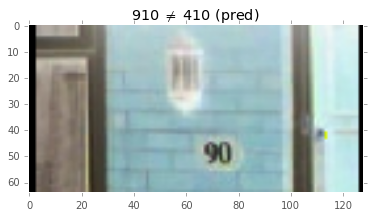

In [136]:
plt.imshow(255*(wrong_x[10] + 0.5))
plt.title('{} $\\neq$ {} (pred)'.format(format_num(wrong_y[10]), format_num(wrong_pred[10])))
plt.grid(False)
plt.show()

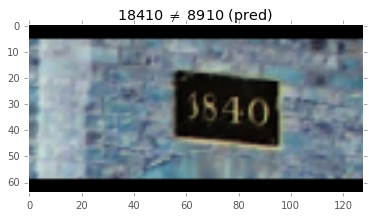

KeyboardInterrupt: 

In [134]:
for i in range(20):
    plt.imshow(255*(wrong_x[i] + 0.5))
    plt.title('{} $\\neq$ {} (pred)'.format(format_num(wrong_y[i]), format_num(wrong_pred[i])))
    plt.grid(False)
    plt.show()
    
    time.sleep(2)
    plt.close('all')
    clear_output()

In [118]:
for i in range(20):
    plt.imshow(255*(right_x[i] + 0.5))
    plt.title('{} = {} (pred)'.format(format_num(right_y[i]), format_num(right_pred[i])))
    plt.grid(False)
    plt.show()
    
    time.sleep(2)
    plt.close('all')
    clear_output()

# Trying deeper model v3

In [26]:
imp.reload(models)

<module 'models' from '/home/ubuntu/Notebooks/models.py'>

In [27]:
deeper_model_v8 = models.make_deeper_model_v8(train_x.shape)

In [28]:
[layer.output_shape for layer in deeper_model_v8.layers]

[(None, 64, 128, 3),
 (None, 64, 128, 50),
 (None, 64, 128, 100),
 (None, 64, 128, 100),
 (None, 32, 64, 100),
 (None, 32, 64, 100),
 (None, 32, 64, 200),
 (None, 32, 64, 200),
 (None, 16, 32, 200),
 (None, 16, 32, 200),
 (None, 16, 32, 200),
 (None, 16, 32, 200),
 (None, 8, 16, 200),
 (None, 8, 16, 200),
 (None, 8, 16, 200),
 (None, 8, 16, 200),
 (None, 4, 8, 200),
 (None, 4, 8, 200),
 (None, 4, 8, 200),
 (None, 2, 4, 200),
 (None, 1600),
 (None, 800),
 (None, 800),
 (None, 55),
 (None, 5, 11),
 (None, 5, 11)]

In [29]:
deeper_model_v8, train_acc5, valid_acc5 = train_model(deeper_model_v8, train_x, train_y, 
                                                    valid_x, valid_y, n_epochs=30, 
                                                    batch_size=20)

41.90 minutes for epoch
capture_performance2(): valid accuracy 0.021197604790419163


KeyboardInterrupt: 

# Trying to use VGG architecture only

In [21]:
imp.reload(models)

<module 'models' from '/home/ubuntu/Notebooks/models.py'>

In [18]:
vgg_model_v3 = models.make_vgg_model_v3(train_x[0].shape)

In [19]:
[layer.output_shape for layer in vgg_model_v3.layers]

[(None, 64, 128, 3),
 (None, 64, 128, 64),
 (None, 64, 128, 64),
 (None, 32, 64, 64),
 (None, 32, 64, 128),
 (None, 32, 64, 128),
 (None, 16, 32, 128),
 (None, 16, 32, 256),
 (None, 16, 32, 256),
 (None, 16, 32, 256),
 (None, 8, 16, 256),
 (None, 8, 16, 512),
 (None, 8, 16, 512),
 (None, 8, 16, 512),
 (None, 4, 8, 512),
 (None, 4, 8, 512),
 (None, 4, 8, 512),
 (None, 4, 8, 512),
 (None, 2, 4, 512),
 (None, 4096),
 (None, 1000),
 (None, 1000),
 (None, 1000),
 (None, 1000),
 (None, 55),
 (None, 5, 11),
 (None, 5, 11)]

In [20]:
vgg_model_v3, train_acc5, valid_acc5 = train_model(vgg_model_v3, train_x, train_y, 
                                                   valid_x, valid_y, n_epochs=30, 
                                                   batch_size=20)

capture_performance2(): valid accuracy 0.00011976047904191617
capture_performance2(): valid accuracy 0.02035928143712575
capture_performance2(): valid accuracy 0.02035928143712575


KeyboardInterrupt: 

# Trying to use Inception modules

In [43]:
imp.reload(models)

<module 'models' from '/home/ubuntu/Notebooks/models.py'>

In [44]:
incp_model_v1 = models.make_inception_model_v1(train_x.shape)

In [45]:
[(depth, [layer.output_shape for layer in layers]) for depth, layers in incp_model_v1.layers_by_depth.items()]

[(0, [(None, 5, 11)]),
 (1, [(None, 5, 11)]),
 (2, [(None, 55)]),
 (3, [(None, 800)]),
 (4, [(None, 800)]),
 (5, [(None, 800)]),
 (6, [(None, 800)]),
 (7, [(None, 1600)]),
 (8, [(None, 2, 4, 200)]),
 (9, [(None, 4, 8, 200)]),
 (10, [(None, 4, 8, 100), (None, 4, 8, 60), (None, 4, 8, 40)]),
 (11, [(None, 4, 8, 100), (None, 4, 8, 60), (None, 4, 8, 200)]),
 (12, [(None, 4, 8, 200)]),
 (13, [(None, 4, 8, 200)]),
 (14, [(None, 8, 16, 200)]),
 (15, [(None, 8, 16, 100), (None, 8, 16, 60), (None, 8, 16, 40)]),
 (16, [(None, 8, 16, 100), (None, 8, 16, 60), (None, 8, 16, 200)]),
 (17, [(None, 8, 16, 200)]),
 (18, [(None, 8, 16, 200)]),
 (19, [(None, 16, 32, 200)]),
 (20, [(None, 16, 32, 100), (None, 16, 32, 60), (None, 16, 32, 40)]),
 (21, [(None, 16, 32, 100), (None, 16, 32, 60), (None, 16, 32, 100)]),
 (22, [(None, 16, 32, 100)]),
 (23, [(None, 16, 32, 100)]),
 (24, [(None, 32, 64, 100)]),
 (25, [(None, 32, 64, 50), (None, 32, 64, 30), (None, 32, 64, 20)]),
 (26, [(None, 32, 64, 50), (None, 32,

11.20 minutes for epoch
capture_performance2(): valid accuracy 0.4932934131736527
Epoch 13
Validation accuracy 49.329%
Mean batch dig loss 0.439
Valid dig loss 0.587


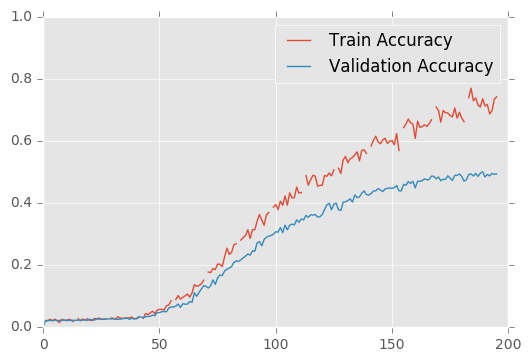

capture_performance2(): valid accuracy 0.492814371257485
capture_performance2(): valid accuracy 0.5076646706586826
capture_performance2(): valid accuracy 0.5069461077844312
capture_performance2(): valid accuracy 0.4986826347305389
capture_performance2(): valid accuracy 0.5074251497005988
capture_performance2(): valid accuracy 0.5101796407185629
capture_performance2(): valid accuracy 0.5015568862275449
capture_performance2(): valid accuracy 0.5093413173652694
capture_performance2(): valid accuracy 0.5065868263473053
capture_performance2(): valid accuracy 0.5069461077844312
capture_performance2(): valid accuracy 0.5159281437125749


KeyboardInterrupt: 

In [46]:
incp_model_v1, train_acc6, valid_acc6 = train_model(incp_model_v1, train_x, train_y, 
                                                    valid_x, valid_y, n_epochs=30, 
                                                    batch_size=20)

# inception try 2

In [47]:
imp.reload(models)

<module 'models' from '/home/ubuntu/Notebooks/models.py'>

In [48]:
incp_model_v2 = models.make_inception_model_v2(train_x.shape)

In [50]:
[(depth, [layer.output_shape for layer in layers]) for depth, layers in incp_model_v2.layers_by_depth.items()]

[(0, [(None, 5, 11)]),
 (1, [(None, 5, 11)]),
 (2, [(None, 55)]),
 (3, [(None, 800)]),
 (4, [(None, 800)]),
 (5, [(None, 800)]),
 (6, [(None, 800)]),
 (7, [(None, 1600)]),
 (8, [(None, 2, 4, 200)]),
 (9, [(None, 3, 7, 200)]),
 (10, [(None, 3, 7, 100), (None, 3, 7, 60), (None, 3, 7, 40)]),
 (11, [(None, 3, 7, 200), (None, 3, 7, 200), (None, 3, 7, 400)]),
 (12, [(None, 3, 7, 400)]),
 (13, [(None, 3, 7, 400)]),
 (14, [(None, 6, 14, 400)]),
 (15, [(None, 6, 14, 200), (None, 6, 14, 120), (None, 6, 14, 80)]),
 (16, [(None, 6, 14, 200), (None, 6, 14, 200), (None, 6, 14, 400)]),
 (17, [(None, 6, 14, 400)]),
 (18, [(None, 6, 14, 400)]),
 (19, [(None, 12, 28, 400)]),
 (20, [(None, 12, 28, 200), (None, 12, 28, 120), (None, 12, 28, 80)]),
 (21, [(None, 12, 28, 60), (None, 12, 28, 60), (None, 12, 28, 120)]),
 (22, [(None, 12, 28, 120)]),
 (23, [(None, 12, 28, 120)]),
 (24, [(None, 24, 56, 120)]),
 (25, [(None, 28, 60, 60)]),
 (26, [(None, 28, 60, 60)]),
 (27, [(None, 56, 120, 60)]),
 (28, [(None, 6

9.58 minutes for epoch
capture_performance2(): valid accuracy 0.6208383233532934
Epoch 10
Validation accuracy 62.084%
Mean batch dig loss 0.433
Valid dig loss 0.482


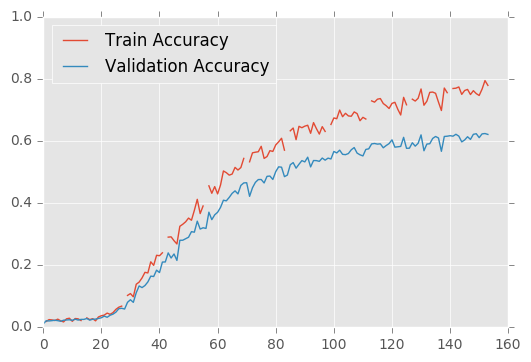

capture_performance2(): valid accuracy 0.6205988023952096
capture_performance2(): valid accuracy 0.6194011976047904
capture_performance2(): valid accuracy 0.611377245508982


KeyboardInterrupt: 

In [51]:
incp_model_v2, train_acc7, valid_acc7 = train_model(incp_model_v2, train_x, train_y, 
                                                    valid_x, valid_y, n_epochs=30, 
                                                    batch_size=20)